In [62]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [63]:
from tensorflow import keras

In [64]:
EXAMINE = 21
SEED = 22
np.random.seed(SEED)

In [65]:
def get_gender_as_num(gender):
    if gender == "male":
        return 0
    else:
        return 1

In [66]:
def get_age_group(age): # HIGH NOTE: changing each of the scalars to a vector. This is probably not a good idea
    if age < 18:
        # 13 - 17
        return [1, 0, 0]
    elif age < 28:
        # 23 - 27
        return [0, 1, 0]
    elif age < 49:
        # 33 - 48
        return [0, 0, 1]
    else:
        return [0, 0, 0]

In [67]:
def get_age_group(age): # HIGH NOTE: changing each of the scalars to a vector. This is probably not a good idea
    age = int(age)
    if age == 18:
        # 13 - 17
        return [1, 0, 0, 0]
    elif age == 25:
        # 23 - 27
        return [0, 1, 0, 0]
    elif age == 35:
        # 33 - 48
        return [0, 0, 1, 0]
    elif age == 50:
        # 33 - 48
        return [0, 0, 0, 1]
    else:
        return [0, 0, 0, 0]

In [68]:
blog_posts_data_dir = "../Datasets/blog-posts-labeled-with-age-and-gender/"
blog_posts_data_dir = "../Datasets/BT-AP-19 Corpus/JSON/all/"
train_file_name = "train.json"
test_file_name = "test.json"

# Load data
with open(blog_posts_data_dir + train_file_name) as r:
    training_set = json.load(r)
training_set[0]

{'post': 'Umar Murtaza: Head of SM Operation', 'age': '50', 'gender': 'female'}

In [69]:
raw_posts = [instance["post"] for instance in training_set]
len(raw_posts)

33637

In [70]:
from tqdm import tqdm
# TODO add stop word filtering 
median_words_per_sample = np.median([len(instance["post"]) for instance in training_set])

# Map each word to a unique int value
MAX_WORD_COUNT = 20000
tokenizer = keras.preprocessing.text.Tokenizer(num_words = MAX_WORD_COUNT)
posts = [instance["post"] for instance in training_set]
tokenizer.fit_on_texts(posts)
word_index = dict(list(tokenizer.word_index.items())[:20000])
sequences = tokenizer.texts_to_sequences(posts)
median_words_per_tokenized_sample = np.median([len(post) for post in sequences])
data = keras.preprocessing.sequence.pad_sequences(sequences, maxlen = int(median_words_per_tokenized_sample)+30,
                                                     padding = "post")
for i, instance in tqdm(enumerate(training_set)):
    instance["post"] = data[i]
    instance["gender"] = get_gender_as_num(instance["gender"])
    instance["age"] = get_age_group(int(instance["age"]))

33637it [00:01, 22211.79it/s]


In [71]:
training_set[0]["post"].__len__()

39

In [72]:
samples_count = len(training_set)

categories_count = len(training_set[0]["age"])

samples_per_class = {0 : 0, 1 : 0, 2 : 0}
for instance in training_set:
    for i, a in enumerate(instance["age"]):
        if a == 1:
            samples_per_class[i] += 1
            break
            

KeyError: 3

In [73]:
print("Number of Samples:", samples_count)
print("Number of Categories:", categories_count)
print("Samples per Class:", samples_per_class)
print("Median Words per Sample:", median_words_per_sample)
print("Median Words per Tokenized Sample:", median_words_per_tokenized_sample)
print("Samples to Words Per Sample Ratio:", samples_count / median_words_per_tokenized_sample)

Number of Samples: 33637
Number of Categories: 4
Samples per Class: {0: 0, 1: 0, 2: 0}
Median Words per Sample: 55.0
Median Words per Tokenized Sample: 9.0
Samples to Words Per Sample Ratio: 3737.4444444444443


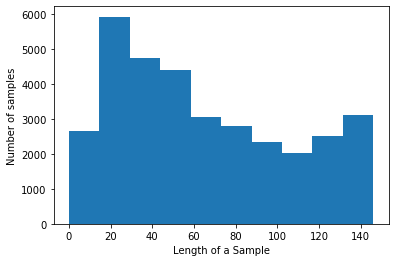

In [74]:
plt.hist([len(instance) for instance in raw_posts])
plt.xlabel("Length of a Sample")
plt.ylabel("Number of samples")
plt.show()

In [75]:
EMBEDDING_DIM = 50

glove_path = "../Models/"
glove_dict = {}
with open(glove_path + "glove.6B.50d.txt") as f:
    for line in f:
        line_values = line.split(" ")
        word = line_values[0]
        embedding_coefficients = np.asarray(line_values[1 : ], dtype = "float32")
        glove_dict[word] = embedding_coefficients

glove_weights = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    glove_vector = glove_dict.get(word)
    if glove_vector is not None:
        glove_weights[i] = glove_vector

In [76]:
glove_weights.__len__()

20001

# Age classification

In [77]:
median_words_per_tokenized_sample

9.0

In [78]:
# Define the model
# Embedding, Conv, Pool, Conv, Pool, Flatten, Dense, Dense
model_1 = keras.Sequential()
model_1.add(keras.layers.Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [glove_weights],
                                    input_length = int(median_words_per_tokenized_sample)+30, trainable = True))
model_1.add(keras.layers.SeparableConv1D(128, 3, activation = "relu"))
model_1.add(keras.layers.MaxPooling1D())
model_1.add(keras.layers.SeparableConv1D(128, 3, activation = "relu"))
model_1.add(keras.layers.MaxPooling1D())
model_1.add(keras.layers.SeparableConv1D(128, 3, activation = "relu"))
model_1.add(keras.layers.MaxPooling1D())
model_1.add(keras.layers.Flatten())
model_1.add(keras.layers.Dense(24, activation = "sigmoid"))
model_1.add(keras.layers.Dense(4, activation = "softmax"))

In [79]:
opt = keras.optimizers.Adam(lr=0.001)
model_1.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ["acc"])
model_1.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 39, 50)            1000050   
_________________________________________________________________
separable_conv1d_18 (Separab (None, 37, 128)           6678      
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 18, 128)           0         
_________________________________________________________________
separable_conv1d_19 (Separab (None, 16, 128)           16896     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 8, 128)            0         
_________________________________________________________________
separable_conv1d_20 (Separab (None, 6, 128)            16896     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 3, 128)           

In [80]:
posts_train = np.array([instance["post"] for instance in training_set])
ages_train = np.array([instance["age"] for instance in training_set])

In [81]:
history_1 = model_1.fit(posts_train, ages_train, epochs = 10, batch_size = 500, validation_split = 0.2)

Epoch 1/10
54/54 [==============================] - 3s 49ms/step - loss: 1.4170 - acc: 0.3164 - val_loss: 1.3025 - val_acc: 0.3112
Epoch 2/10
54/54 [==============================] - 3s 48ms/step - loss: 1.3039 - acc: 0.3384 - val_loss: 1.2717 - val_acc: 0.3789
Epoch 3/10
54/54 [==============================] - 3s 47ms/step - loss: 1.2727 - acc: 0.3700 - val_loss: 1.2266 - val_acc: 0.4144
Epoch 4/10
54/54 [==============================] - 3s 47ms/step - loss: 1.2266 - acc: 0.4115 - val_loss: 1.1982 - val_acc: 0.4313
Epoch 5/10
54/54 [==============================] - 3s 53ms/step - loss: 1.1744 - acc: 0.4449 - val_loss: 1.1722 - val_acc: 0.4478
Epoch 6/10
54/54 [==============================] - 3s 50ms/step - loss: 1.1236 - acc: 0.4808 - val_loss: 1.1678 - val_acc: 0.4512
Epoch 7/10
54/54 [==============================] - 3s 54ms/step - loss: 1.0723 - acc: 0.5187 - val_loss: 1.1528 - val_acc: 0.4680
Epoch 8/10
54/54 [==============================] - 3s 57ms/step - loss: 1.0146 - a

In [89]:
from keras import layers

# A integer input for vocab indices.
inputs = keras.Input(shape=int(median_words_per_tokenized_sample)+30, dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(len(word_index) + 1, EMBEDDING_DIM)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(4, activation="sigmoid", name="predictions")(x)

model_3 = tf.keras.Model(inputs, predictions)

In [90]:
# model_3.compile(optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["acc"])
model_3.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model_3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 39)]              0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 39, 50)            1000050   
_________________________________________________________________
dropout_4 (Dropout)          (None, 39, 50)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 11, 128)           44928     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2, 128)            114816    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               1651

In [91]:
posts_train.shape

(33637, 39)

In [92]:
history_3 = model_3.fit(posts_train, ages_train, epochs = 10, batch_size = 500, validation_split = 0.2)

Epoch 1/10
54/54 [==============================] - 3s 38ms/step - loss: 1.3309 - accuracy: 0.3082 - val_loss: 1.2730 - val_accuracy: 0.3743
Epoch 2/10
54/54 [==============================] - 2s 33ms/step - loss: 1.2615 - accuracy: 0.3843 - val_loss: 1.1591 - val_accuracy: 0.4570
Epoch 3/10
54/54 [==============================] - 2s 33ms/step - loss: 1.1110 - accuracy: 0.4828 - val_loss: 1.1189 - val_accuracy: 0.4886
Epoch 4/10
54/54 [==============================] - 2s 33ms/step - loss: 0.9852 - accuracy: 0.5588 - val_loss: 1.1429 - val_accuracy: 0.4899
Epoch 5/10
54/54 [==============================] - 2s 34ms/step - loss: 0.8685 - accuracy: 0.6195 - val_loss: 1.1458 - val_accuracy: 0.5128
Epoch 6/10
54/54 [==============================] - 2s 35ms/step - loss: 0.7517 - accuracy: 0.6790 - val_loss: 1.2054 - val_accuracy: 0.5122
Epoch 7/10
54/54 [==============================] - 2s 36ms/step - loss: 0.6492 - accuracy: 0.7243 - val_loss: 1.2589 - val_accuracy: 0.5186
Epoch 8/10
54

In [99]:
# Load data
with open(blog_posts_data_dir + test_file_name) as r:
    test_set = json.load(r)

In [100]:
test_posts = [instance["post"] for instance in test_set]
test_sequences = tokenizer.texts_to_sequences(test_posts)
test_post_data = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen = int(median_words_per_tokenized_sample)+30,
                                                     padding = "post")
for i, instance in enumerate(test_set):
    instance["post"] = test_post_data[i]
    instance["gender"] = get_gender_as_num(instance["gender"])
    instance["age"] = get_age_group(int(instance["age"]))

In [101]:
posts_test = np.array([instance["post"] for instance in test_set])
ages_test = np.array([instance["age"] for instance in test_set])

In [102]:
model_1.evaluate(posts_test, ages_test)

263/263 [==============================] - 0s 2ms/step - loss: 1.2177 - acc: 0.4750


[1.2177083492279053, 0.47502973675727844]

In [103]:
model_3.evaluate(posts_test, ages_test)

263/263 [==============================] - 0s 1ms/step - loss: 1.4348 - accuracy: 0.5190


[1.4348442554473877, 0.5190249681472778]

In [43]:
model_1.save('../Models/CNN_model')

INFO:tensorflow:Assets written to: ../Models/CNN_model/assets


In [104]:
from sklearn.metrics import classification_report

In [105]:
pred = model_3.predict(posts_test)

In [106]:
pred = model_3.predict(posts_test)
print(classification_report(np.argmax(ages_test, axis=1), np.argmax(pred, axis=1)))

              precision    recall  f1-score   support

           0       0.57      0.66      0.61      2698
           1       0.47      0.53      0.50      2647
           2       0.55      0.38      0.45      2309
           3       0.43      0.39      0.41       756

    accuracy                           0.52      8410
   macro avg       0.50      0.49      0.49      8410
weighted avg       0.52      0.52      0.51      8410



# Gender classification

In [109]:
# Define the model
# Embedding, Conv, Pool, Conv, Pool, Flatten, Dense, Dense
model_2 = keras.Sequential()
model_2.add(keras.layers.Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [glove_weights],
                                    input_length = int(median_words_per_tokenized_sample)+30, trainable = True))
model_2.add(keras.layers.SeparableConv1D(50, 5, activation = "relu"))
model_2.add(keras.layers.MaxPooling1D())
model_2.add(keras.layers.SeparableConv1D(100, 3, activation = "relu"))
model_2.add(keras.layers.MaxPooling1D())
model_2.add(keras.layers.Flatten())
model_2.add(keras.layers.Dense(10, activation = "sigmoid"))
model_2.add(keras.layers.Dense(1, activation = "sigmoid"))

In [110]:
posts_train = np.array([instance["post"] for instance in training_set])
genders_train = np.array([instance["gender"] for instance in training_set])

In [111]:
model_2.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["acc"])
model_2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 39, 50)            1000050   
_________________________________________________________________
separable_conv1d_23 (Separab (None, 35, 50)            2800      
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 17, 50)            0         
_________________________________________________________________
separable_conv1d_24 (Separab (None, 15, 100)           5250      
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 7, 100)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 700)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)              

In [112]:
history_2 = model_2.fit(posts_train, genders_train, epochs = 10, batch_size = 500, validation_split = 0.2)

Epoch 1/10
54/54 [==============================] - 2s 36ms/step - loss: 0.6556 - acc: 0.6782 - val_loss: 0.6206 - val_acc: 0.6806
Epoch 2/10
54/54 [==============================] - 2s 34ms/step - loss: 0.6126 - acc: 0.6867 - val_loss: 0.6085 - val_acc: 0.6806
Epoch 3/10
54/54 [==============================] - 2s 32ms/step - loss: 0.5960 - acc: 0.6858 - val_loss: 0.5742 - val_acc: 0.7057
Epoch 4/10
54/54 [==============================] - 2s 30ms/step - loss: 0.5484 - acc: 0.7210 - val_loss: 0.5548 - val_acc: 0.7174
Epoch 5/10
54/54 [==============================] - 2s 28ms/step - loss: 0.5165 - acc: 0.7503 - val_loss: 0.5410 - val_acc: 0.7316
Epoch 6/10
54/54 [==============================] - 2s 29ms/step - loss: 0.4836 - acc: 0.7735 - val_loss: 0.5295 - val_acc: 0.7424
Epoch 7/10
54/54 [==============================] - 2s 29ms/step - loss: 0.4339 - acc: 0.8050 - val_loss: 0.5201 - val_acc: 0.7504
Epoch 8/10
54/54 [==============================] - 1s 27ms/step - loss: 0.3865 - a

In [113]:
posts_test = np.array([instance["post"] for instance in test_set])
genders_test = np.array([instance["gender"] for instance in test_set])

In [114]:
model_2.evaluate(posts_test, genders_test)

263/263 [==============================] - 0s 1ms/step - loss: 0.5308 - acc: 0.7669


[0.5307836532592773, 0.7669441103935242]

In [115]:
from sklearn.metrics import classification_report

In [116]:
pred = model_2.predict(posts_test)

In [117]:
print(classification_report(genders_test, (pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.65      0.51      0.57      2565
           1       0.80      0.88      0.84      5845

    accuracy                           0.77      8410
   macro avg       0.73      0.70      0.71      8410
weighted avg       0.76      0.77      0.76      8410

